In [257]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns





#from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score


from sklearn.pipeline import Pipeline


from tqdm import tqdm
import time

# *Methods* 

In [390]:
#method to compute the confusion matrix 
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


#method to plot the matrix 
def plot_confusion_matrix(confusion_matrix):
    
    [[TP, FP],[FN, TN]] = confusion_matrix  #define the matrix
    
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]]) #label the boxes of the confusion matrix
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative'])  
    
    return sns.heatmap(df_cm, cmap='GnBu', annot=label, annot_kws={"size": 16}, cbar=False, fmt='') #plot heatmap


#compute the score 
def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    #calculate the precision  (what fraction of positive predictions is true)
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    #calculate the recall (what fraction of positive example are recognized as such)
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan
    
    #harmonic mean of the recall and precision

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [374]:
def accuracy (matrix_confusion) : 
  
 #recover the different performance of the classifier 
    [t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(matrix_confusion)
    
 #print them 

    print("The accuracy of this model is {0:1.3f}".format(accuracy))
    print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
    print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))
    

In [375]:
def features_imp (train_f, params) :
    
    tmp = []
    for name, value in zip(train_f, params):
        tmp.append({"name": name, "value": value}) #concatenate value and names of the features

    features_coef = pd.DataFrame(tmp).sort_values("value")
    features_coef.head() # visualise first coefficient
    
    plt.subplots(figsize=(8,25))
    ax = sns.barplot(y= features_coef.name, x=features_coef.value, palette ="light:b")   #plot features_names and their relative importance into the model
 


## *Data preparation*

We recovered data from Handling_categorical_data and separate it to train and test set to performs our classification for climate.

In [105]:
data_original = pd.read_csv("data/one_hot.bz2", compression = 'bz2') #load the data one hot encoding

In [241]:
data = data_original.drop(['label'], axis=1).copy() #drop the label column
data.head(3)

,date_of_birth,climate,['association football player'],['politician'],['actor'],['writer'],['researcher'],['painter'],['visual artist'],['journalist'],...,"['transgender female', 'male']","['transgender female', 'female']","['intersex', 'non-binary']",['genderqueer'],['cisgender female'],"['intersex', 'female']","['male', 'transgender female']","['female', 'non-binary']",['transgender person'],['cisgender male']
0,1952,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1946,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1945,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*preparation of our features*

In [244]:
X = data.drop(['climate'],axis=1)
y = data['climate']

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #split data into train and test set 

## *Fit To “Baseline” Logistic classification*

Now we create a “baseline” for logistic classifier with stochastic gradient. This model uses all of the unmodified features and the default settings defined in the Scikit-learn logistic regression documentation. Basline model are simple model that are less likely to overfit and likely to be interpretable. it can helps us to get a better view on our data and show us a direction for the feature engineering. Moreover, comparaison between baseline and engineered model will helps us to conclude about our classification. 

The accuracy of this model is 0.983
For the positive case, the precision is nan, the recall is 0.000 and the F1 score is nan
For the negative case, the precision is 0.983, the recall is 1.000 and the F1 score is 0.992


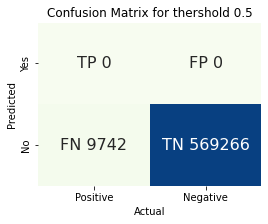

In [391]:
logistic=LogisticRegression(max_iter = 1000) #we indicate this parameters otherwise the model does not converge
logistic.fit(X_train, y_train)

prediction_proba=logistic.predict_proba(X_test) 
    
#construct the confusion matrix
confusion_matrix_05_baseline = compute_confusion_matrix(y_test, prediction_proba, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_baseline)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_baseline)

Based on the baselin model we can observe that our data is largely imbalanced : the classifier tend to alway predict 0 for climate and still get an amazing accarucy ! However, if we take a look at the F-score for positive case, we can observe that it is null... In fact, climate speakers are in minority in our data and so we need to modify our training set to get a satisfy classification. 

## *Modification of our training set*

*undersampling*

In [342]:
print('We have {} speakers talking about climate'.format(len(data_features[data_features['climate']==1])))
print('We have {} speakers that do not talking about climate'.format(len(data_features[data_features['climate']==0])))

We have 48722 speakers talking about climate
We have 2846314 speakers that do not talking about climate


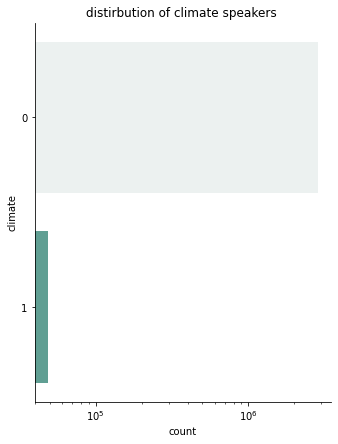

In [392]:
ax = sns.catplot(y="climate", data=data,
                kind="count", height=6, aspect=.8, palette="light:#5A9")
ax.set(xscale='log', title = 'distirbution of climate speakers ')
plt.show()

As we can see we have an  imbalanced datasets examples where climate speakers are in the minority class. This distribution cause bias in the training dataset and can influence our classification leading some to ignore the minority class entirely. We decided to manage this problem by randomly resampling the training dataset. The two main approaches are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling. In frame with the dimension of our dataset we decided to go with undersamplig.

In [340]:
undersample = RandomUnderSampler(sampling_strategy=1) #stategy = 1, majority class yill be the same amount as the minority class (1 to 1)

# fit and apply the transform into the train set
X_smote, y_smote = undersample.fit_resample(X_train, y_train)

In [351]:
print('Before undersampling we get {} non climate outcome, after undersampling we get {} climate outcome'.format(y_train.value_counts()[0], y_smote.value_counts()[0]))

Before undersampling we get 2277048 non climate outcome, after undersampling we get 38980 climate outcome


As we get a large number of features, dimensionality reduction could be an option, let's visualize the variance explained by each feature in order to select an interval containing the major components for the PCA 

*PCA on training set*

In [531]:
#scale our dataset : Standardize features by removing the mean and scaling to unit variance.
scaler=StandardScaler()
scaler.fit(X_smote)
train_scaled = pd.DataFrame(scaler.transform(X_smote), columns=X_smote.columns) 
test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) 

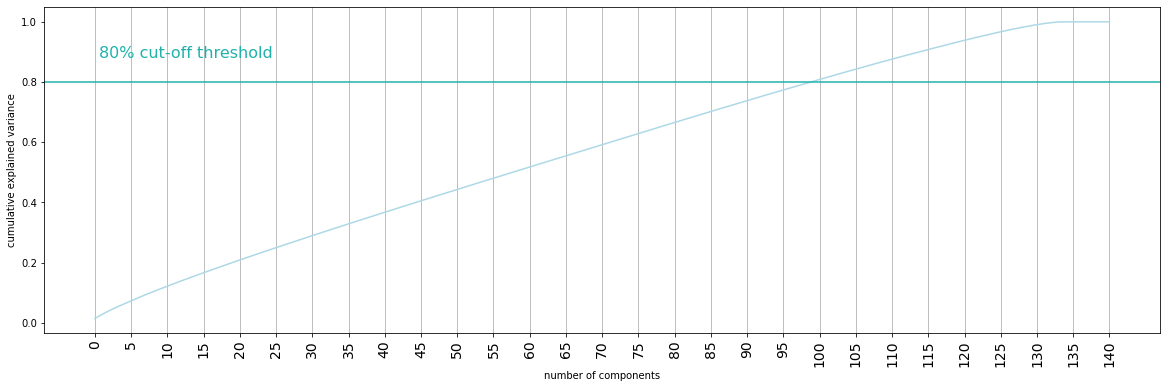

In [353]:
pca = PCA().fit(train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'lightblue')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.axhline(y=0.8, color='lightseagreen', linestyle='-')
plt.text(0.5, 0.88, '80% cut-off threshold', color = 'lightseagreen', fontsize=16)
plt.xticks(np.arange(0, 142, step=5), rotation=90, fontsize=14)
plt.grid(axis='x')
plt.show()

In [354]:
#Creation of Dataframe containing the major components
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(100))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.015158,0.015158
1,0.028388,0.013230
2,0.040978,0.012590
3,0.052314,0.011336
4,0.062982,0.010668
...,...,...
95,0.773801,0.007069
96,0.780830,0.007029
97,0.787841,0.007011
98,0.794831,0.006991


Based on the graph we can see that each component does not have a great explained variance (<<0.02..), it seems that component beyteen 95 and 100 are required to explained at least 80% of the variance.

## *Logistic Regression*

Logistic regression measures the relationship between variable by estimating probabilities using a logistic function.
One thing we may want to do is rescale the features/inputs. Rescaling data brings values that may have extremely different ranges or units into alignment with one another. Bringing all the measurements into a similar scale helps the performance of the classifier (for a comparison try dropping the scaling and see how your performance decreases), and we can accomplish this with the StandardScaler from sklearn library. Another idea as already mention is to test for PCA.

*without  scaling and PCA*

In [327]:
#declaration of a pipe flow

pipe = Pipeline([('logistic',LogisticRegression())])
    

# pipe flow is :
#  undersample train data  -> logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001,0.01,  0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict(logistic__penalty=penalty,
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.78613813184117
Best Params:  {'logistic__C': 0.1, 'logistic__max_iter': 1000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}


*standarized without PCA* 

In [328]:
#declaration of a pipe flow

pipe = Pipeline([('std_slc', StandardScaler()),  
                 ('logistic',LogisticRegression()), ]
                 )
    
    
# pipe flow is :
#  Scaling the data -> logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001,0.01,  0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict(logistic__penalty=penalty,
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.806747090902677
Best Params:  {'logistic__C': 0.1, 'logistic__max_iter': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Best Params:  {'logistic__C': 0.1, 'logistic__max_iter': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}


*With PCA*

In [533]:
#declaration of a pipe flow
pipe = Pipeline([('std_slc', StandardScaler()),
                ('pca', PCA()),
                ('logistic',LogisticRegression())])
    
    
# pipe flow is :
# PCA(Dimension reduction to two) -> Scaling the data -> logistic regression


#different parameters for hypertunning
n_components=[95, 100]
penalty = ['l2'] 
solver=['lbfgs']
max_iter=[100, 1000, 10000]
C = [0.001, 0.1, 1, 10, 100]


# make lists of different parameters to check
param_grid = dict(logistic__class_weight =class_weight, pca__n_components=n_components, logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 



    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv =5) 
    
#fit
grid_result = grid.fit(X_smote, y_smote) 
    
#print score and params of the best model
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

-> we can see that the second model returns the best accuracy: let's use it for our classification. 

## *Let's see the result !*

The accuracy of this model is 0.790
For the positive case, the precision is 0.053, the recall is 0.683 and the F1 score is 0.099
For the negative case, the precision is 0.993, the recall is 0.791 and the F1 score is 0.881


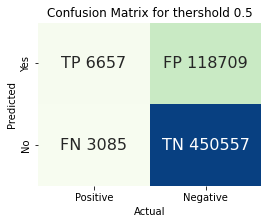

In [535]:
logistic=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=0.1, max_iter=1000)
logistic.fit(train_scaled, y_smote)

prediction_proba=logistic.predict_proba(test_scaled) 
    
#construct the confusion matrix
confusion_matrix_05_model = compute_confusion_matrix(y_test, prediction_proba, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_model)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_model)
    

#### 2.2 - Remove features vs not 

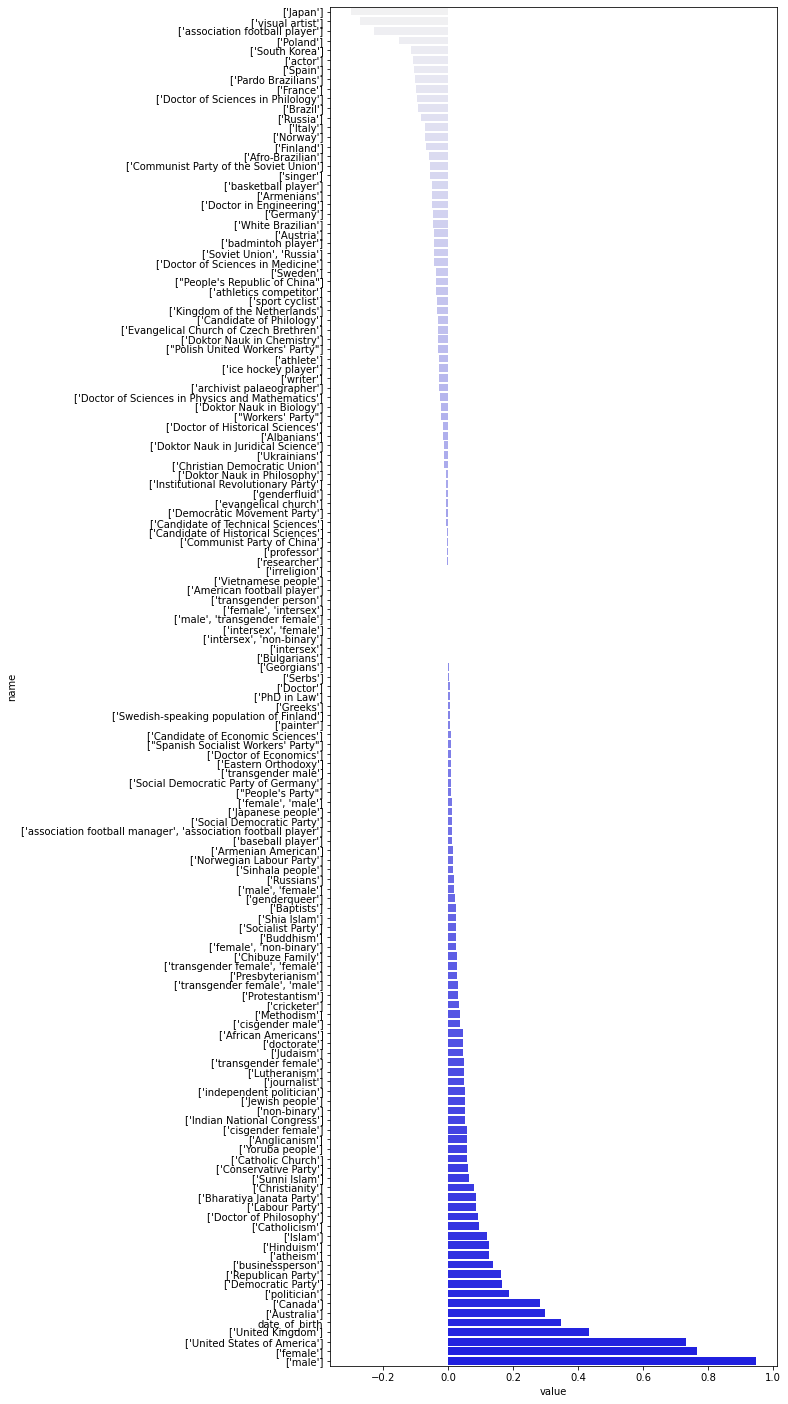

In [536]:
features_imp (X_smote.columns, logistic.coef_[0])

In [546]:
sub_features_train=train_scaled.iloc[:,np.where(logistic.coef_[0]>0.1)[0]]
sub_features_test =test_scaled.iloc[:,np.where(logistic.coef_[0]>0.1)[0]]

The accuracy of this model is 0.824
For the positive case, the precision is 0.059, the recall is 0.630 and the F1 score is 0.108
For the negative case, the precision is 0.992, the recall is 0.828 and the F1 score is 0.903


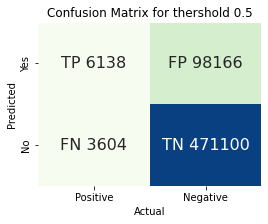

In [547]:
logistic_bis=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=0.1, max_iter=100)
logistic_bis.fit(sub_features_train, y_smote)

prediction_proba=logistic_bis.predict_proba(sub_features_test) 
    
#construct the confusion matrix
confusion_matrix_05_sub_model = compute_confusion_matrix(y_test, prediction_proba, 0.5)

plt.figure(figsize = (4,3))   
ax = plot_confusion_matrix(confusion_matrix_05_sub_model)

#setting axis
plt.xlabel('Actual')
plt.ylabel('Predicted')
ax.set(title = 'Confusion Matrix for thershold 0.5')
    
#get the accuracy of the model
accuracy (confusion_matrix_05_sub_model)

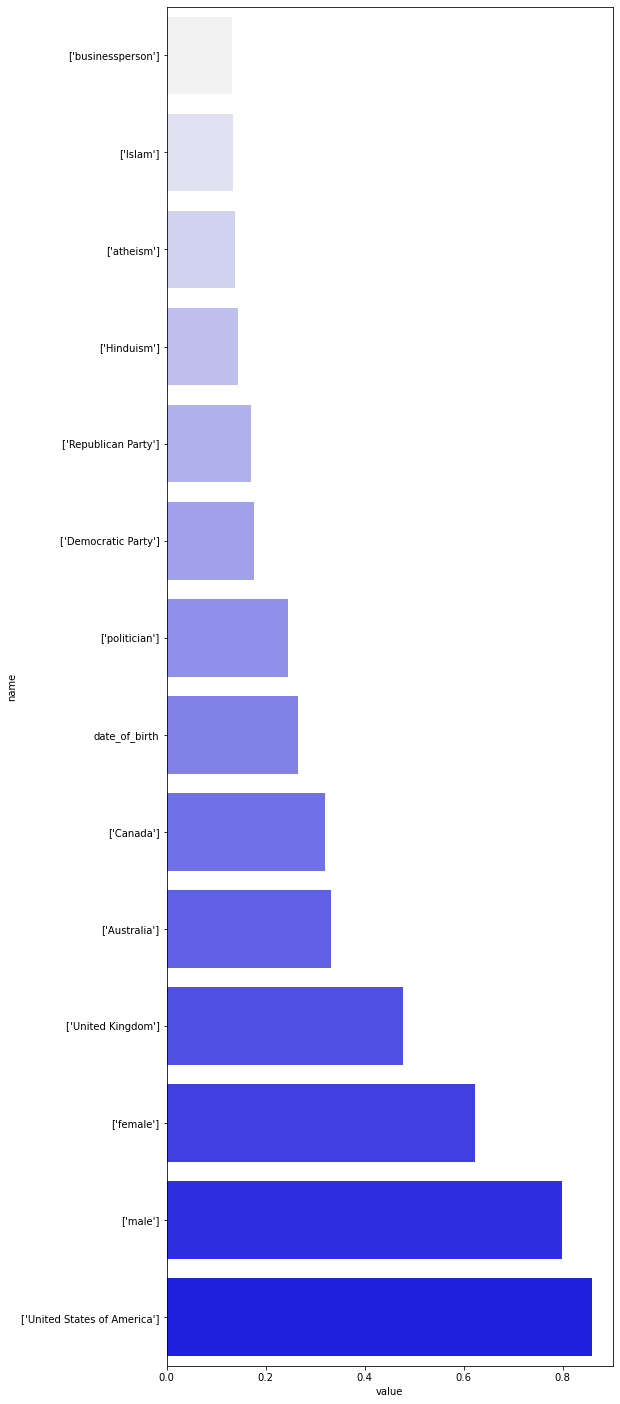

In [548]:
features_imp (sub_features_train.columns, logistic_bis.coef_[0])

#### 2.2 - classification per caracheristic 

In [555]:
occupation_train, occupation_test = [X_smote.iloc[:, 1:21], X_smote.iloc[:, 1:21]]
gender_train, gender_test = [X_smote.iloc[:, 121:141], X_smote.iloc[:, 121:141]]
nationality_train, nationality_test =[X_smote.iloc[:, 61:81], X_smote.iloc[:, 61:81]]
academic_degree_train, academic_degree_test =[X_smote.iloc[:, 101:121], X_smote.iloc[:, 101:121]]

In [556]:
dico={'occupation' : occupation_train, 'gender' : gender_train, 'nationality ':nationality_train, 'academic_degree' : academic_degree_train }

In [557]:
#declaration of a pipe flow
pipe = Pipeline([('logistic',LogisticRegression())])
    
    
# pipe flow is :
#  Scaling the data -> SDGClassifier


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs']
max_iter=[10000]
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000] 


# make lists of different parameters to check
param_grid = dict( logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 




# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
    
#fit
for name, data in dico.items() :
    grid_result = grid.fit(data, y_smote)  
    print(f'Best Score for {name}: ', grid_result.best_score_) 
    print(f'Best Params for {name}: ', grid_result.best_params_) 

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for occupation:  0.6023925272093594
Best Params for occupation:  {'logistic__C': 10, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for gender:  0.5391266021358916
Best Params for gender:  {'logistic__C': 1000, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for nationality :  0.5150524972878172
Best Params for nationality :  {'logistic__C': 0.1, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score for academic_degree:  0.5058996572027439
Best Params for academic_degree:  {'logistic__C': 10, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}


In [558]:
#declaration of a pipe flow
pipe = Pipeline([('std_slc', StandardScaler()),
                ('logistic',LogisticRegression())])
    
    
# pipe flow is :
# Scaling the data -> Logistic regression


#different parameters for hypertunning

penalty = ['l2'] 
solver=['lbfgs', 'sag']
max_iter=[10000]
C = [0.001, 0.01, 0.1, 1, 10, 100] 


# make lists of different parameters to check
param_grid = dict( logistic__penalty=penalty, 
logistic__C=C,logistic__solver=solver,logistic__max_iter=max_iter) 




    
# initialize
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 5) 
#fit
for name, data in dico.items() :
    grid_result = grid.fit(data, y_smote)  
    print(f'Best Score for {name}: ', grid_result.best_score_) 
    print(f'Best Params for {name}: ', grid_result.best_params_) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for occupation:  0.6023925272093594
Best Params for occupation:  {'logistic__C': 0.01, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for gender:  0.5390531589787925
Best Params for gender:  {'logistic__C': 0.01, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'sag'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for nationality :  0.5150483970940881
Best Params for nationality :  {'logistic__C': 100, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score for academic_degree:  0.5058996670747995
Best Params for academic_degree:  {'logistic__C': 0.001, 'logistic__max_iter': 10000, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}


In [560]:
#scale our dataset : Standardize features by removing the mean and scaling to unit variance.
train_scaled_occ = pd.DataFrame(preprocessing.scale(occupation_train),columns =occupation_train.columns) 
test_scaled_occ = pd.DataFrame(preprocessing.scale(occupation_test),columns =occupation_test.columns) 


train_scaled_gender = pd.DataFrame(preprocessing.scale(gender_train),columns =gender_train.columns) 
test_scaled_gender = pd.DataFrame(preprocessing.scale(gender_test),columns =gender_test.columns) 

train_scaled_nationality = pd.DataFrame(preprocessing.scale(nationality_train),columns =nationality_train.columns) 
test_scaled_nationality = pd.DataFrame(preprocessing.scale(nationality_test),columns =nationality_test.columns) 

train_scaled_academic_degree= pd.DataFrame(preprocessing.scale(academic_degree_train),columns =academic_degree_train.columns) 
test_scaled_academic_degree = pd.DataFrame(preprocessing.scale(academic_degree_test),columns =academic_degree_test.columns) 


## *Let's see the result !*

In [561]:
logistic_occupation=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=0.01, max_iter=10000)
logistic_occupation.fit(occupation_train, y_smote)
prediction_proba_occupation=logistic_bis.predict_proba(occupation_tesst) 

logistic_gender=LogisticRegression(solver ='sag', penalty = 'l2', C=0.01, max_iter=10000)
logistic_gender.fit(train_scaled_gender, y_smote)
prediction_proba_gender=logistic_gender.predict_proba(test_scaled_gender) 

logistic_nationality=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=100, max_iter=10000)
logistic_nationality.fit(train_scaled_nationality, y_smote)
prediction_proba_nationality=logistic_nationality.predict_proba(test_scaled_nationality ) 

logistic_academic_degree=LogisticRegression(solver ='lbfgs', penalty = 'l2', C=0.001, max_iter=10000)
logistic_academic_degree.fit(train_scaled_academic_degree, y_smote)
prediction_academic_degree=logistic_bis.predict_proba(test_scaled_academic_degree) 


/Users/yousraferiel/opt/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- ['Candidate of Economic Sciences']
- ['Candidate of Historical Sciences']
- ['Candidate of Philology']
- ['Candidate of Technical Sciences']
- ['Doctor in Engineering']
- ...
Feature names seen at fit time, yet now missing:
- ['Australia']
- ['Canada']
- ['Democratic Party']
- ['Hinduism']
- ['Islam']
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 20 features, but LogisticRegression is expecting 14 features as input.

In [134]:
for name, data in dico.items() :
    

/Users/yousraferiel/opt/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- ['Catholic Church']

  warnings.warn(message, FutureWarning)


ValueError: X has 20 features, but SGDClassifier is expecting 21 features as input.